# LECTURE 07: NEURAL NETWORKS PART TWO

## References

### Blogs, code snippets, lecture notes, research papers, etc.

- <a href=http://www.cs.toronto.edu/~graves/preprint.pdf>$\texttt{http://www.cs.toronto.edu/~graves/preprint.pdf}$</a> A book on sequence labeling

- <a href=http://www.cs.toronto.edu/~graves/phd.pdf>$\texttt{http://www.cs.toronto.edu/~graves/phd.pdf}$</a> A Ph.D. thesis focused on RNNs

- <a href=https://github.com/gwtaylor/theano-rnn/blob/master/rnn.py>$\texttt{https://github.com/gwtaylor/theano-rnn/blob/master/rnn.py}$</a> A theano implementation of a RNN (our RNN experiments below draw heavily from this code)

- <a href=http://neuralnetworksanddeeplearning.com/chap6.html>$\texttt{http://neuralnetworksanddeeplearning.com/chap6.html}$</a> An introduction to convolutional neural networks (the rest of the website has other material too)

- <a href=http://arxiv.org/abs/1311.2901>$\texttt{http://arxiv.org/abs/1311.2901}$</a> This paper uses various visualizations to give some intuition for how convolutional neural networks actually work

- <a href=http://deeplearning.net/tutorial/lenet.html>$\texttt{http://deeplearning.net/tutorial/lenet.html}$</a>  Here's some example code for a convolutional network. Be aware that if you choose to run it, it will likely take hours to train...

- <a href=http://cs231n.github.io/convolutional-networks/>$\texttt{http://cs231n.github.io/convolutional-networks/}$</a> Another introductory tutorial to convolutional networks, with some useful illustrations and links

- <a href=http://web.engr.illinois.edu/~slazebni/spring14/lec24_cnn.pdf>$\texttt{http://web.engr.illinois.edu/~slazebni/spring14/lec24_cnn.pdf}$</a> Lecture notes on (deep) convolutional neural networks

- <a href=http://timdettmers.com/2015/03/26/convolution-deep-learning/>$\texttt{http://timdettmers.com/2015/03/26/convolution-deep-learning/}$</a> Blog post on convolution in deep learning

- <a href=http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/>$\texttt{http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/}$</a> Stanford tutorial on autoencoders

- <a href=http://cs.stanford.edu/~quocle/tutorial2.pdf>$\texttt{http://cs.stanford.edu/~quocle/tutorial2.pdf}$</a> A tutorial that covers autoencoders, convolutional neural networks, and RNNs!

- <a href=http://www.cs.nyu.edu/~yann/talks/lecun-ranzato-icml2013.pdf>$\texttt{http://www.cs.nyu.edu/~yann/talks/lecun-ranzato-icml2013.pdf}$</a> A talk on deep learning



# Recurrent Neural Networks (RNNs)

<img src="sequence_labeling.png">
The goal (graphic reproduced from Alex Graves)

<img src="defence.png">
The importance of context: sequences should be modeled as sequences (graphic reproduced from Alex Graves)

## Introduction

Feed-forward neural networks as introduced in the previous lecture are great but they also suffer from some limitations. One obvious limitation is the following: they are built to accept input of a fixed size/type and generate output of a fixed size/type. If I train a feed-forward neural network to classify hand-written digits encoded as $28 \times 28$ real matrices, it's not immediately clear how I might try to use that neural network to classify hand-written digits of a different size (e.g. $29 \times 29$). 

What's even less clear is how I might try to classify a string of hand-written digits. If I knew how to segment the image into smaller patches (each of which corresponds to a single digit) then I could use my classifier separately on each patch. But how do I do the segmentation? And even if I know how to do the segmentation well, I'm losing information by applying the single-digit classifier separately to each image patch. For example, suppose I have two sevens next to one another and suppose that the writer is a classy person who always puts horizontal lines through the middle of her 7s. Suppose further that the first one is relatively easy to classify but the second one is a bit messy. If I do the classification of each digit separately, I will probably get the first digit right and the second digit wrong. But if I classify the two digits _jointly_ then there's the hope that the classifier will 'learn' that the writer makes sevens in a certain way and is more likely to correctly classify the second digit correctly too.

As another example, consider the US Post Office classifying street addresses. If I'm classifying the string from left to right and I've so far identified 'STREE' and the next letter is in fact a 'T' it should be easy for me to correctly classify the whole string as 'STREET'---even if the final letter is quite messy. But in order to do that I need to do some kind of joint classification.

These are the sorts of situations where a RNN can potentially be useful. In particular a RNN has the potentially very useful property that it can approximate functions that map input sequences of _arbitrary length_ to output sequences of _arbitrary length_.

### Graphical representation of an unfolded RNN
#### Basically we tie together a bunch of feed-forward neural networks (graphic reproduced from Alex Graves)

<img src="unfolded_rnn.png">

## Mathematical representation

Consider an input sequence $\{\bf x_1, x_2, ..., x_T \}$ where each $\bf x_t \in \mathbb{R}^D$. There will be $M$ hidden units. The RNN will generate an output sequence $\{\bf y_1, y_2, ..., y_T \}$ where each $\bf y_t \in \mathbb{R}^K$. The activations will be defined as follows:

$$\begin{equation}
{\bf a_t} = {\bf W^{({\rm i}\to{\rm h})} x_t + \bf W^{({\rm h}\to{\rm h})} z_{t-1} } \qquad \rm{for} \qquad t=1,2,...,T
\end{equation}$$

while the hidden states will be defined as 

$$\begin{equation}
{\bf z_t} = h( \bf a_t) \qquad \rm{for} \qquad t=1,2,...,T
\end{equation}$$

where, as before, $h(\cdot)$ is our non-linearity that maps the activation into the hidden state.

Here ${\bf W^{({\rm i}\to{\rm h})}}$ is a $M \times D$ matrix that maps the input into the activation. Note that this weight matrix _does not_ depend on time: we use the same weight matrix for all $t$. If we had only this one term the RNN would be pretty similar to the feed-forward neural network except that we're applying a separate weight matrix to each piece of the input separately. 

It's the next term that really sets the RNN apart. In the next term $\bf W^{({\rm h}\to{\rm h})}$ is a $M \times M$ matrix that maps the _previous_ hidden state $\bf z_{t-1}$ to a new $M$-dimensional vector that contributes to the _current_ activation ${\bf a_t}$. In this way information seen in previous parts of the input sequence can propagate through the RNN and is available at the current time step.

At this point we still need to define the output sequence $\{\bf y_1, y_2, ..., y_T \}$. Recall that in the feed-forward neural network the output is defined via a transformation (or some serious of transformations) of the hidden units. Here we do the same thing (and as before, there is flexibility in how exactly we do this):

$$\begin{equation}
{\bf y_t} = \bf W^{({\rm h}\to{\rm o})} z_t \qquad \rm{for} \qquad t=1,2,...,T
\end{equation}$$

where we have introduced a $K \times M$ weight matrix $\bf W^{({\rm h}\to{\rm o})}$ that maps the hidden unit at time $t$, i.e. $\bf z_t$, into the output at time $t$, i.e. $\bf y_t$.

### Further details and loose ends

#### Bias vectors

So much for the basic setup. One thing we omitted that we will generally want to have is bias vectors (exactly as in the case of the feed-forward neural network). To simplify notation we didn't include them, but they will in general be be important if we are to get good performance. Indeed all of the RNN code snippets below make use of bias vectors (in particular one on the activation and one on the output).

#### The initial hidden unit $z_0$

Notice that the activation for the first time step, i.e. ${\bf a_1}$, depends on the hidden unit $z_0$. However, we didn't define what $z_0$ is. At this point we have two options. One possibility is to set $z_0$ to some arbitrary fixed constant (e.g. $z_0 = 0$). Another possibility is to make $z_0$ a parameter of our model that we learn during training. Note that since $z_0$ has $M$ parameters while, e.g., the hidden-to-hidden weight matrix $\bf W^{({\rm h}\to{\rm h})}$ has $M^2$ parameters, including $z_0$ as a free parameter won't increase the total number of parameters by very much. 

#### The vanishing/exploding gradients problem 

To learn parameters in this sort of context we typically do some form of gradient descent. But the gradients of (the cost function of) a RNN can be ill-behaved. To see this let's consider the (simplified) case where $\bf W^{({\rm i}\to{\rm h})}=0$. Let's unroll the functional dependence of $\bf z_t$:

$$\begin{equation}
{\bf z_t} = h( \bf a_t) = h(\bf W^{({\rm h}\to{\rm h})} z_{t-1}) =
h(\bf W^{({\rm h}\to{\rm h})} h( \bf a_{t-1})) = 
h(\bf W^{({\rm h}\to{\rm h})} h( \bf \bf W^{({\rm h}\to{\rm h})} z_{t-2} ))
\end{equation}$$

For simplicity let's set $h=1$, i.e. we set $h$ equal to the identity function so we have:

$$\begin{equation}
{\bf z_t} = 
\bf W^{({\rm h}\to{\rm h})} \bf \bf W^{({\rm h}\to{\rm h})} z_{t-2}
\end{equation}$$

So if we keep unrolling the chain we find the weight matrix raised to a (potentially) high power:

$$\begin{equation}
{\bf z_t} = 
\bf \left ( W^{({\rm h}\to{\rm h})} \right)^{t-1} z_{1}
\end{equation}$$

Now let's suppose that $\bf W^{({\rm h}\to{\rm h})}$ has an eigenvector $\bf \tilde{z}$ with eigenvalue $\lambda$:


$$\begin{equation}
{\bf W^{({\rm h}\to{\rm h})} \tilde{z} } = \lambda {\bf \tilde{z}}
\end{equation}$$

Then if we set $\bf z_1 = \tilde{z}$ we have:

$$\begin{equation}
{\bf z_t} = \lambda^{t-1} {\bf \tilde{z}}
\end{equation}$$

If $\lambda>1$ and $t$ is large then small changes in $\bf W^{({\rm h}\to{\rm h})}$ (which lead to small changes in $\lambda$) will lead to huge changes in ${\bf z_t}$. Conversely, if $\lambda<1$ and $t$ is large then small changes in $\bf W^{({\rm h}\to{\rm h})}$ (which lead to small changes in $\lambda$) will lead to hardly any sort of change in ${\bf z_t}$, since in that case $\lambda^{t-1} \approx0$ with the consequence that ${\bf z_t} \approx 0$. This is what is referred to as the vanishing/exploding gradients problem. This leads to ill-behaved gradients and makes learning via gradient descent problematic. Similar problems hold in deep architectures for similar reasons.

## Other architectures (i.e. more complicated architectures)
### Bi-directional recurrent neural networks (graphic reproduced from Alex Graves)
<img src="unfolded_brnn.png">

## Example: RNN with $D=5$ and $K=3$
Here the RNN has to learn a pretty simple pattern where the ouputs are simple shifts of the inputs (plus some noise).

... building the model
... training
epoch 50, seq 100/100, train loss 0.826773 lr: 0.000952
epoch 100, seq 100/100, train loss 0.288564 lr: 0.000906
epoch 150, seq 100/100, train loss 0.276488 lr: 0.000862
epoch 200, seq 100/100, train loss 0.272131 lr: 0.000819
epoch 250, seq 100/100, train loss 0.163444 lr: 0.000779
epoch 300, seq 100/100, train loss 0.013554 lr: 0.000741
epoch 350, seq 100/100, train loss 0.009538 lr: 0.000705
epoch 400, seq 100/100, train loss 0.008040 lr: 0.000671


rnn.py:336: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <type 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.python2x.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  self.y: train_set_y[index]})


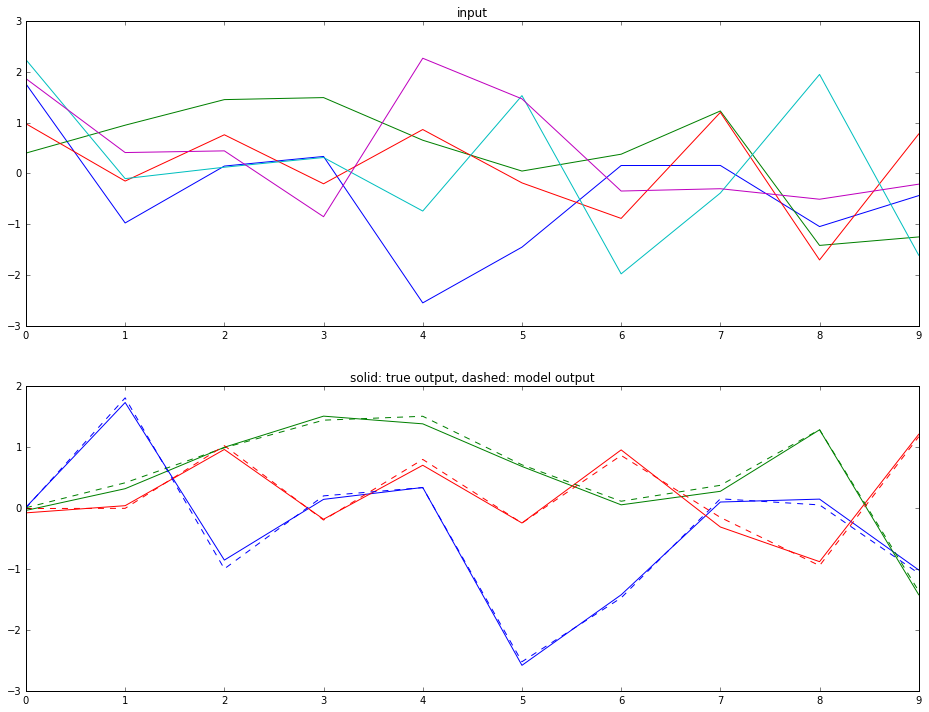

In [1]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rnn import RNN, MetaRNN

n_hidden = 10 # M
n_in = 5      # D
n_out = 3     # K
n_steps = 10  # the length of each sequence
n_seq = 100   # the number of datapoints (i.e. sequences)

np.random.seed(0)
seq = np.random.randn(n_seq, n_steps, n_in)
targets = np.zeros((n_seq, n_steps, n_out))

# targets contains all the input sequences
targets[:, 1:, 0] = seq[:, :-1, 0]  # the first output is just a shifted version of the first input (shift = 1)
targets[:, 1:, 1] = seq[:, :-1, 1]  # the second output is just a shifted version of the second input (shift = 1)
targets[:, 2:, 2] = seq[:, :-2, 2]  # the third output is just a shifted version of the third input (shift = 2)
                                    # the fourth and fifth outputs are ignored
targets += 0.05 * np.random.standard_normal(targets.shape) # add noise

model = MetaRNN(n_in=n_in, n_hidden=n_hidden, n_out=n_out,
                    learning_rate=0.001, learning_rate_decay=0.999,
                    n_epochs=400, activation='tanh')
model.fit(seq, targets, validation_frequency=5000)

fig = plt.figure(figsize=[16,12]);
ax1 = plt.subplot(211);
plt.plot(seq[0]);
ax1.set_title('input');

ax2 = plt.subplot(212);
true_targets = plt.plot(targets[0]);

guess = model.predict(seq[0])
guessed_targets = plt.plot(guess, linestyle='--');
for i, x in enumerate(guessed_targets):
    x.set_color(true_targets[i].get_color());
ax2.set_title('solid: true output, dashed: model output'); # show rnn prediction for a single sequence

## Example: RNN with binary outputs
In this case the RNN is being used to define a probabilistic model, i.e. it's being used to parameterize

$$\begin{equation}
P({\bf y_1, y_2, ..., y_T} | {\bf x_1, x_2, ..., x_T})
\end{equation}$$

This is in exact analogy to our feed-forward neural network being used to parameterize a probabilistic model that does digit classification. Only here the input size is not fixed!
Notice that for binary outputs this requires that the RNN output one real number per time step (i.e. one real number for the Bernoulli parameter $\eta_t$ at time $t$) for a total of $T$ outputs. For an arbitrarily long input sequence $\{ {\bf x_1, x_2, ..., x_T} \}$ the RNN fully specifies the probability distribution on $\{ {\bf y_1, y_2, ..., y_T} \}$.


... building the model
... training
epoch 100, seq 100/100, train loss 0.663908 lr: 0.000906
epoch 200, seq 100/100, train loss 0.049474 lr: 0.000819
epoch 300, seq 100/100, train loss 0.013025 lr: 0.000741
epoch 400, seq 100/100, train loss 0.005424 lr: 0.000671


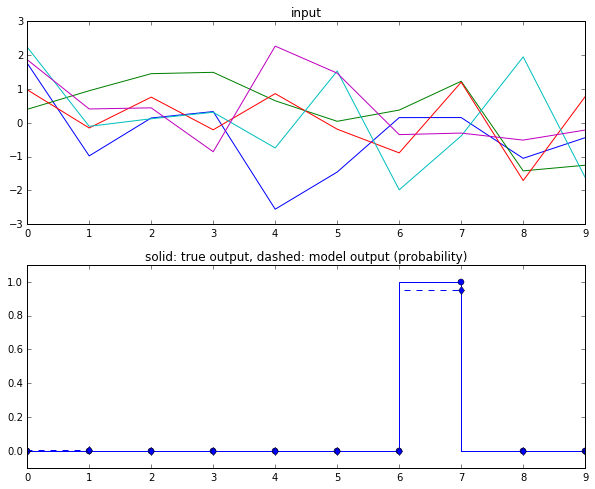

In [3]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rnn import RNN, MetaRNN

n_epochs = 400
n_hidden = 10
n_in = 5
n_out = 1
n_steps = 10
n_seq = 100

np.random.seed(0)
seq = np.random.randn(n_seq, n_steps, n_in)
targets = np.zeros((n_seq, n_steps, n_out))

# whether lag 1 (dim 0 i.e. blue) is greater than lag 2 (dim 1 i.e. green)
targets[:, 2:, 0] = np.cast[np.int](seq[:, 1:-1, 0] > seq[:, :-2, 1])

model = MetaRNN(n_in=n_in, n_hidden=n_hidden, n_out=n_out,
                    learning_rate=0.001, learning_rate_decay=0.999,
                    n_epochs=n_epochs, activation='tanh', output_type='binary')
model.fit(seq, targets, validation_frequency=10000)

seqs = xrange(1) # consider a single test sequence during plotting

for seq_num in seqs:
    fig = plt.figure(figsize=[10,8])
    ax1 = plt.subplot(211)
    plt.plot(seq[seq_num])
    ax1.set_title('input')
    ax2 = plt.subplot(212)
    true_targets = plt.step(xrange(n_steps), targets[seq_num], marker='o')

    guess = model.predict_proba(seq[seq_num])
    guessed_targets = plt.step(xrange(n_steps), guess)
    plt.setp(guessed_targets, linestyle='--', marker='d')
    for i, x in enumerate(guessed_targets):
        x.set_color(true_targets[i].get_color())
    ax2.set_ylim((-0.1, 1.1))
    ax2.set_title('solid: true output, dashed: model output (probability)') 

<br><br><br>
# Convolutional neural networks and computer vision

## Introduction

When we discussed feed-forward neural networks in the previous lecture, we focused on neural networks with a single layer of hidden units. As we saw, with a sufficiently large number of hidden units these can be used to approximate arbitrary continuous functions from $\mathbb{R}^D$ to $\mathbb{R}^K$ (well, at least on compact domains). So why would we ever bother to use a neural network with more hidden layers?

One of the "insights" of so-called deep learning approaches is that it is often more efficient (i.e. a fewer number of weight parameters are needed) to approximate certain classes of functions with neural networks that have multiple hidden layers. What's more, experimental results show that the promised advantages of more efficient representations/parameterizations from deep neural networks are not purely academic---for certain datasets, machine learning systems can benefit tremendously from some depth. The goal of this section is to give an introduction to deep architectures by describing the generic architecture of a convolutional neural network, which has been successfully applied in a variety of computer vision tasks. Instead of getting tied up in math, let's just give an intuitive introduction to some of the main elements that make up these machine learning systems.

## Local receptive fields

Recall that so far we've primarily looked at fully-connected neural networks. For a neural network with a single hidden layer and many hidden units, this results in a lot of parameters since the first weight matrix satisfies ${\bf W^{(1)}} \in \mathcal{M}_{MD}$ and the second weight matrix satisfies ${\bf W^{(2)}} \in \mathcal{M}_{KM}$. If $M$ is large $M\times D$ and $K\times M$ are potentially very large numbers. In the present case, where we imagine the input to be a large image, we could easily have $D \sim 1000 \times 1000 = 10^6$. Evidently, the total number of parameters could easily spin out of control if we kept to fully-connected neural networks.

One obvious way to combat this problem is to have far fewer connections between units. One specific way to do this is to introduce the so-called local receptive field: instead of tying each hidden unit to _all_ of the input units, we only tie each hidden unit to a small patch of the input. Evidently, this has the potential to _drastically_ reduces the total number of parameters in our neural network.

<img src="lrf1.png">
<img src="lrf2.png">
Illustrating local receptive fields: each hidden unit is connected to a $5 \times 5$ patch of the input (figure from Michael Nielsen)





## Shared weights

One way to conceptualize what hidden units are 'doing' is that each hidden unit is primed to respond to certain 'features' in the input. For example, a certain component of a hidden unit might turn on when it sees a horizonal line in its local receptive field. We might suppose that these sorts of features should be spatially invariant: what I call a horizontal line in the left field of my vision shouldn't be different from what I call a horizontal line in the right field of my vision. So we should use the same features in both places. Which means we should use the same weight matrices. So in the two images above, we use identical weights to connect both patches to their respective hidden units. Not only does this automatically give us a certain kind of spatial invariance but, importantly, it also _drastically_ reduces the number of parameters we need to define our neural network. 

## (Max-)pooling

This is a way of condensing the information found in the convolutional layers into a smaller number of hidden units. For example, in max-pooling a given hidden unit in the pooling layer will be on if _any_ of the hidden units in the patch of the convolutional layer that feed into the max-pooling unit are on. The pooling layer thus gives a way of summarizing the information in the convolutional layer. Some details are lost (e.g. the precise positions of activated features) but the resulting representation is more slender and will be easier for subsequent layers to process.
<br><br>
<img src="lenet.png">

_An architectural schematic for a (relatively simple & old-school) convolutional neural network (Figure from <a href=http://deeplearning.net/tutorial/lenet.html>$\texttt{http://deeplearning.net/tutorial/lenet.html}$</a>)_

<br>

## And other stuff too

This has been a very cursory introduction to convolutional neural networks. Check out some of the links in the references sections if you're curious to learn more.
<br><br><br>


# Autoencoders

So far we've used neural networks in the supervised learning setting. Can neural networks be of any use in the _unsupervised_ learning setting, where we don't have any outputs or target labels for the inputs? The answer is **yes**, and one broad class of neural networks that can be used in this context goes under the general heading of _autoencoders_.

All our cost functions so far have depended on some kind of labels/output. So how could we possibly train a neural network without labels/output? The answer, of course, is to use the inputs as the outputs! In order words, we train the neural network to **reconstruct** the input from the input (thus the name: an autoencoder encodes itself and decodes that code to reconstruct the input). If we set things up sensibly, the autoencoder will 'learn' something useful about the data.

<img src="autoencoder.png">
_A graphic illustration of a neural network autoencoder with a single hidden layer (Adapted from the Stanford tutorial)_

The danger, of course, is that if we set things up badly, the autoencoder might just learn the identity function (or something very nearly equal to the identity function), which obviously isn't going to be very useful. Let's look at a few possible architectures to understand all this a little bit better.

To begin with, consider our generic neural network with a single hidden layer that targets maps from $\mathbb{R}^D$ to $\mathbb{R}^K$. We set $D=K$ and use the input as the output. We use the mean squared error as the cost function during training. Let's suppose that $M$, the number of hidden units, satisfies $M<D$. Let's also suppose the that non-linearity $h$ is just the identity function. What's going to happen during training? Evidently the neural network can't learn a perfect identity function: there's a bottleneck since all the information that flows through the network has to go through the $M<D$ hidden units. So what happens? If you were paying attention during the PCA lecture and/or have good intuition, then it's sort of clear what's going to happen: the neural network is going to learn to map the input onto the leading $M$ eigenvectors of the data covariance matrix $\bf S$, i.e. the neural network is going to learn how to do PCA. That's interesting---but we already know how to do PCA. 

What about if we introduce a non-linearity? In that case it's possible that we'll learn something more interesting. Note, however, that in general we need to include some sort of constraint to ensure that the neural network doesn't just learn to use the identity function (for which the cost is identically zero). We're not going to go into the details here, but one possibility is to include a term in the cost function that promotes _sparse weights_, in the sense that most activations are off for most points in the dataset. For an example of the kind of structure that a (in this case sparse) autoencoder can learn, check out the set of feature maps learned from a set of natural images (graphic reproduced from the Stanford tutorial). Evidently, the autoencoder has identified various edge-like features. This could potentially be useful in the supervised learning setting as a set of features in image classification.

<img src="autoencoder_weights.png">